## A Spiking Neural Model of Action Planning

This is a notebook that presents and implements the model described in a paper submitted for consideration at the 2016 Conference of the Cognitive Science Society. Running this model requires a working installation of the Nengo simulation package, along with matplotlib for plotting simulation results. To plot spike rasters, the plotting library nengo_plot is required (https://github.com/tcstewar/nengo_plot). For more details, please refer to the accompanying paper. 

We first define a simulated world or environment using a simple python library. We can print the state of this environment as follows:

In [1]:
import os 
import numpy as np
import nengo
import nengo.spa as spa
# import nengo_plot  # Uncomment this line if nengo_plot is installed
import world
import kitchen
import nodes_lite
import matplotlib.pyplot as plt
%matplotlib inline

from nengo.networks import AssociativeMemory, Product 

world = kitchen.get_kitchen()
world.print_state()

D = 256 # SP dimensionality. 

WATER
{'TEMPERATURE': 'COLD'}
------------------
KETTLE
{'PLUGGED': 'PLUGGED_IN'}
ON-COUNTER
------------------
TAP
{'OFFON': 'OFF'}
------------------
COUNTER
{}
------------------


Next, we define vocabularies for various components of the model. These describe the structured semantic pointers that various subsystems in the model recognize and process: 

In [2]:
base_items= ['LOCATION','GOAL','GARAGE','HOLE_MADE','STAFF_LOUNGE','WATER_BOILED','KITCHEN','HOME_DEPOT',
             'KETTLE_UNPLUGGED','KETTLE_PLUGGED_IN','WATER_IN_KETTLE','KETTLE_UNDER_TAP','EFFECTS','OBJECT']

objects = ['DRILL','KETTLE','TAP']
actions = ['FILL_KETTLE_FROM_TAP', 'PUT_KETTLE_UNDER_TAP', 'BOIL_KETTLE', 'PLUG_IN_KETTLE','UNPLUG_KETTLE']
effects = ['WATER_IN_KETTLE', 'KETTLE_UNDER_TAP', 'WATER_BOILED', 'KETTLE_PLUGGED_IN', 'KETTLE_UNPLUGGED']
precons = ['KETTLE_UNDER_TAP','KETTLE_UNPLUGGED','WATER_IN_KETTLE','KETTLE_PLUGGED_IN','HAS_CORD']
signals = ['PLAN','ACT','DONE']

base_vocab = spa.Vocabulary(D)
signal_vocab = spa.Vocabulary(D)

for item in base_items:
    base_vocab.parse(item)

# Ensures shared representations across vocabs for objects and actions
obj_vocab = base_vocab.create_subset(base_items)
obj_id_vocab = base_vocab.create_subset(base_items)
act_id_vocab = base_vocab.create_subset(base_items)
act_vocab = base_vocab.create_subset(base_items)

# Build structured semantic pointers for objects
sp = base_vocab.parse('LOCATION*KITCHEN+LOCATION*STAFF_LOUNGE+LOCATION*HOME_DEPOT+GOAL*WATER_BOILED')
sp.normalize()
obj_vocab.add('KETTLE', sp)

sp = base_vocab.parse('LOCATION*KITCHEN+LOCATION*STAFF_LOUNGE+GOAL*WATER_BOILED')
sp.normalize()
obj_vocab.add('TAP', sp)

sp = base_vocab.parse('LOCATION*GARAGE+LOCATION*HOME_DEPOT+GOAL*HOLE_MADE')
sp.normalize()
obj_vocab.add('DRILL', sp)

# Build structured semantic pointers for actions
sp = base_vocab['OBJECT'] * obj_id_vocab['KETTLE'] + (base_vocab['EFFECTS'] * base_vocab['WATER_BOILED'])
sp.normalize()
act_vocab.add('BOIL_KETTLE', sp)

sp = base_vocab['OBJECT'] * obj_id_vocab['KETTLE'] + (base_vocab['EFFECTS'] * base_vocab['KETTLE_PLUGGED_IN'])
sp.normalize()
act_vocab.add('PLUG_IN_KETTLE', sp)

sp = base_vocab['OBJECT'] * obj_id_vocab['KETTLE'] + (base_vocab['EFFECTS'] * base_vocab['KETTLE_UNPLUGGED'])
sp.normalize()
act_vocab.add('UNPLUG_KETTLE', sp)

sp = base_vocab['OBJECT'] * obj_id_vocab['TAP'] + (base_vocab['EFFECTS'] * base_vocab['WATER_IN_KETTLE'])
sp.normalize()
act_vocab.add('FILL_KETTLE_FROM_TAP', sp)

sp = base_vocab['OBJECT'] * obj_id_vocab['KETTLE'] + (base_vocab['EFFECTS'] * base_vocab['KETTLE_UNDER_TAP'])
sp.normalize()
act_vocab.add('PUT_KETTLE_UNDER_TAP', sp)

# Create ID semantic pointers for objects and actions
for obj in objects:
    obj_id_vocab.parse(obj)

for action in actions:
    act_id_vocab.parse(action)
    
for sig in signals:
    signal_vocab.parse(sig)
    
act_id_vocab['PUSH'].make_unitary() # for manipulating stack

goal_check_vocab = base_vocab.create_subset(effects)
goal_check_vocab.add('DONE', signal_vocab['DONE'].v)

# For defining associative memory that cleans up actions to preconditions
inp_vecs = np.zeros((3, D))
out_vecs = np.zeros((3, D))

inp_vecs[0,:] = act_id_vocab['FILL_KETTLE_FROM_TAP'].v
inp_vecs[1,:] = act_id_vocab['PUT_KETTLE_UNDER_TAP'].v
inp_vecs[2,:] = act_id_vocab['BOIL_KETTLE'].v

out_vecs[0,:] = base_vocab['KETTLE_UNDER_TAP'].v
out_vecs[1,:] = base_vocab['KETTLE_UNPLUGGED'].v
out_vecs[2,:] = 0.4* base_vocab['WATER_IN_KETTLE'].v + 0.6*base_vocab['KETTLE_PLUGGED_IN'].v

Now we can define the actual model structure as a collection of components and modules in accordance with the Semantic Pointer Architecture. These components correspond to the components depicted in Figure 1 of the paper as indicated by the comments below.

In [3]:
motor_sys = nodes_lite.MotorSystem(act_id_vocab, world)
vision_sys = nodes_lite.VisualSystem(act_id_vocab, world)
check_sys = nodes_lite.CheckSystem(goal_check_vocab, world)

with spa.SPA() as model:
    
    # World interface nodes (Motor and Perception)
    model.motor = nengo.Node(motor_sys, size_in=D, size_out=1)
    model.sense = nengo.Node(vision_sys, size_in=D, size_out=1)
    model.check = nengo.Node(check_sys, size_in=D, size_out=1)

    # Main state representations    
    model.m_goal = spa.Memory(dimensions=D, vocab=base_vocab)
    model.i_goal = spa.Memory(dimensions=D, vocab=base_vocab, synapse=0.005, tau=0.05)
    model.action = spa.Memory(dimensions=D, vocab=act_id_vocab, synapse=0.005, tau=0.03)
    model.effect = spa.Memory(dimensions=D, vocab=base_vocab, synapse=0.005, tau=0.05)
    model.precon = spa.Memory(dimensions=D, vocab=base_vocab, synapse=0.005, tau=0.05)
    model.location = spa.State(dimensions=D, vocab=base_vocab)
  
    # For managing control signal representation
    model.ctrl = spa.Memory(dimensions=D, tau=0.05) 
    model.switch = spa.Memory(dimensions=D, vocab=signal_vocab, synapse=0.1, tau=0.15)
    model.gate = spa.Memory(dimensions=1, neurons_per_dimension=250)
    model.prod = Product(n_neurons=200, dimensions=1) 
    model.const = nengo.Node(1, size_out=1) # bias for computing a gate signal
    model.sig = spa.Memory(dimensions=D, vocab=signal_vocab, synapse=0.1, tau=0.65)

    # Associative Memories 
    model.loc_to_object = spa.AssociativeMemory(input_vocab=obj_vocab, output_vocab=obj_id_vocab,
                                                input_keys=objects, output_keys=objects,
                                                wta_output=False, threshold=.5)
    
    model.obj_to_action = spa.AssociativeMemory(input_vocab=act_vocab, output_vocab=act_id_vocab, 
                                                input_keys=actions, output_keys=actions,
                                                wta_output=True, threshold=.9)
    
    model.action_to_effect = spa.AssociativeMemory(input_vocab=act_id_vocab, output_vocab=base_vocab,
                                                   input_keys=actions, output_keys=effects, wta_output=True)
   
    model.cleanup_action = spa.AssociativeMemory(act_id_vocab, threshold=0.15, wta_output=True)
    model.action_to_precon = AssociativeMemory(input_vectors=inp_vecs, output_vectors=out_vecs)  
    
    
    model.get_precon = spa.State(dimensions=D, vocab=act_id_vocab)

    # Stack implementation
    model.push = spa.Memory(dimensions=D, vocab=act_id_vocab, synapse=0.005, tau=0.05)
    model.stack = spa.Memory(dimensions=D, vocab=act_id_vocab, synapse=0.005, tau=0.5)
    
    # Motor input to interface to world                       
    model.premotor = spa.Memory(dimensions=D, vocab=act_id_vocab, synapse=0.005, tau=0.03)
    
    # Connection between modules                  
    nengo.Connection(model.location.output, model.loc_to_object.input, 
                     transform=base_vocab['LOCATION'].get_convolution_matrix())
    nengo.Connection(model.m_goal.state.output, model.loc_to_object.input, 
                     transform=base_vocab['GOAL'].get_convolution_matrix())
    
    nengo.Connection(model.loc_to_object.output, model.obj_to_action.input, 
                     transform=base_vocab['OBJECT'].get_convolution_matrix())
    nengo.Connection(model.i_goal.state.output, model.obj_to_action.input, 
                     transform=base_vocab['EFFECTS'].get_convolution_matrix())
                           
    nengo.Connection(model.const, model.prod.A)
    nengo.Connection(model.gate.state.output, model.prod.B)
    nengo.Connection(model.prod.output, model.sig.state.input, transform=0.4*signal_vocab['PLAN'].v.reshape(D,1))
    nengo.Connection(model.m_goal.state.output, model.check[:])
    nengo.Connection(model.check, model.switch.state.input, transform=signal_vocab['DONE'].v.reshape(D,1))
    nengo.Connection(model.get_precon.output, model.action_to_precon.input)
    nengo.Connection(model.action_to_precon.output, model.precon.state.input)
    
    nengo.Connection(model.push.state.output, model.sense[:])
    nengo.Connection(model.premotor.state.output, model.motor[:])
    nengo.Connection(model.sense, model.switch.state.input, transform=0.6*signal_vocab['ACT'].v.reshape(D,1))
      
                           
    # Control system - specifies utilities and effects of cognitive actions                  
    bg_actions = spa.Actions(
        'dot(ctrl, PLAN)       -->  i_goal=m_goal, ctrl=GET_ACTION',
        'dot(ctrl, GET_ACTION) -->  action=obj_to_action, ctrl=GET_PRECON',
        'dot(ctrl, GET_PRECON) -->  get_precon=2*action, push=1.5*(stack*PUSH+action), ctrl=SET_GOAL',
        'dot(ctrl, SET_GOAL)   -->  i_goal=1.5*i_goal+1.2*precon-effect, stack=push, ctrl=GET_ACTION',
        
        'dot(switch, ACT)      -->  ctrl=TOP_PLAN, gate=1, switch=-1*ACT',
        'dot(ctrl, TOP_PLAN)   -->  cleanup_action=stack, ctrl=POP_PLAN',
        'dot(ctrl, POP_PLAN)   -->  push=(stack-premotor)*~PUSH, ctrl=SET_PLAN',
        'dot(ctrl, SET_PLAN)   -->  stack=10*push, ctrl=TOP_PLAN',
        'dot(sig, PLAN)        -->  ctrl=PLAN, gate=-0.45',
        'dot(switch, DONE)     -->  ctrl=DONE',
        '0.5                   -->  ')

    ct_actions = spa.Actions(
        'action_to_effect=action',
        'effect=action_to_effect',
        'premotor=cleanup_action')
    
    model.bg = spa.BasalGanglia(bg_actions)
    model.ct = spa.Cortical(ct_actions)
    model.thal = spa.Thalamus(model.bg)

    def set_goal(t):
        return 'WATER_BOILED'

    def set_location(t):
        return 'KITCHEN'
    
    def set_plan(t):
        if 0.03 < t < 0.07: return 'PLAN'
        else: return '0'

    # Initial input to model
    model.start = spa.Input(m_goal=set_goal, ctrl=set_plan, location=set_location)

    # Representational Probes
    goal_probe = nengo.Probe(model.i_goal.state.output, synapse=0.03) 
    ctrl_probe = nengo.Probe(model.ctrl.state.output, synapse=0.03)
    motor_probe = nengo.Probe(model.premotor.state.output, synapse=0.03)
    stack_probe = nengo.Probe(model.stack.state.output, synapse=0.03)
    
    # Spike Probes
    goal_spikes = nengo.Probe(model.i_goal.state.ea_ensembles[2].neurons, 'spikes')
    ctrl_spikes = nengo.Probe(model.ctrl.state.ea_ensembles[4].neurons, 'spikes')
    motor_spikes = nengo.Probe(model.premotor.state.ea_ensembles[7].neurons, 'spikes')
    stack_spikes = nengo.Probe(model.stack.state.ea_ensembles[6].neurons, 'spikes')
    
sim = nengo.Simulator(model, seed=np.random.randint(1))

We can now define a couple of functions to plot results 

In [4]:
import pylab

goal_keys = ['KETTLE_UNDER_TAP','KETTLE_PLUGGED_IN','','WATER_IN_KETTLE','KETTLE_UNPLUGGED','WATER_BOILED']
action_keys = ['UNPLUG_KETTLE', 'BOIL_KETTLE','PLUG_IN_KETTLE','FILL_KETTLE_FROM_TAP','PUT_KETTLE_UNDER_TAP']

def plot_results(sim):
    fig = plt.figure(figsize=(16,8))
    n = 4
    p1 = fig.add_subplot(n,1,1)
    p1.plot(sim.trange(), model.similarity(sim.data, goal_probe))
    p1.legend(['','KETTLE_UNPLUGGED','KETTLE_PLUGGED_IN','WATER_IN_KETTLE','KETTLE_UNDER_TAP','WATER_BOILED'], 
               fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p1.set_ylabel('Immediate Goal', fontsize=14)

    p2 = fig.add_subplot(n,1,2)
    p2.plot(sim.trange(), model.similarity(sim.data, ctrl_probe))
    p2.legend(model.get_output_vocab('ctrl').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=10)
    p2.set_ylabel('Control Signal', fontsize=14)

    p3 = fig.add_subplot(n,1,3)
    p3.plot(sim.trange(), model.similarity(sim.data, stack_probe))
    p3.legend(actions, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p3.set_ylabel('Plan', fontsize=14)

    p4 = fig.add_subplot(n,1,4)
    p4.plot(sim.trange(), model.similarity(sim.data, motor_probe))
    p4.legend(actions, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p4.set_ylabel('Motor Output', fontsize=14)
    
    fig.subplots_adjust(hspace=0.6)
    fig.savefig(os.path.join('tests', 'example run'))
    plt.show()
    
def plot_spikes(sim):
    plot = nengo_plot.Time(sim.trange(), width=16, height=8)
    plot.add('', model.similarity(sim.data, goal_probe)) 
    pylab.yticks([-1,0,1], fontsize=12)
    pylab.ylabel('Goal', fontsize=16)
    pylab.legend(goal_keys, fontsize=10, loc='lower right', ncol=8)
    plot.add_spikes('', sim.data[goal_spikes], height=0.8, sample_by_variance=64, cluster=True)

    plot.add('Control Signal', model.similarity(sim.data, ctrl_probe)) 
    pylab.yticks([-1,0,1], fontsize=12)
    pylab.ylabel('Control Signal', fontsize=16)
    pylab.legend(model.get_output_vocab('ctrl').keys, fontsize=10, loc='lower right', ncol=8)
    plot.add_spikes('', sim.data[ctrl_spikes], height=0.8,  sample_by_variance=64, cluster=True)
    
    plot.add('', model.similarity(sim.data, stack_probe))
    pylab.yticks([-1,0,1], fontsize=12)
    pylab.ylabel('Plan', fontsize=16)
    pylab.legend(action_keys, fontsize=10, loc='lower right', ncol=6)
    plot.add_spikes('', sim.data[stack_spikes], height=0.8, sample_by_variance=64, cluster=True)
    
    plot.add('', model.similarity(sim.data, motor_probe))
    pylab.yticks([-1,0,1], fontsize=12)
    pylab.ylabel('Motor', fontsize=16)
    pylab.legend(action_keys, fontsize=10, loc='lower right', ncol=6)
    plot.add_spikes('', sim.data[motor_spikes], height=0.8, sample_by_variance=64, cluster=True)
    plot.save('spikes.png')
    

Now, we can simulate the model's behavior for a specifed amount of time and plot the results. We can also display the current state of the environment to confirm that the specified goal has been achieved.

In [5]:
sim.run(2.5)

[#################            28%                              ] ETA: 0:01:34performing action UNPLUG_KETTLE
[###################          32%                              ] ETA: 0:01:28performing action PUT_KETTLE_UNDER_TAP
[#######################      37%                              ] ETA: 0:01:20performing action FILL_KETTLE_FROM_TAP
[############################ 53%                              ] ETA: 0:01:01performing action PLUG_IN_KETTLE
[############################ 58% ###                          ] ETA: 0:00:54performing action BOIL_KETTLE
Simulation finished in 0:02:09.                                                 


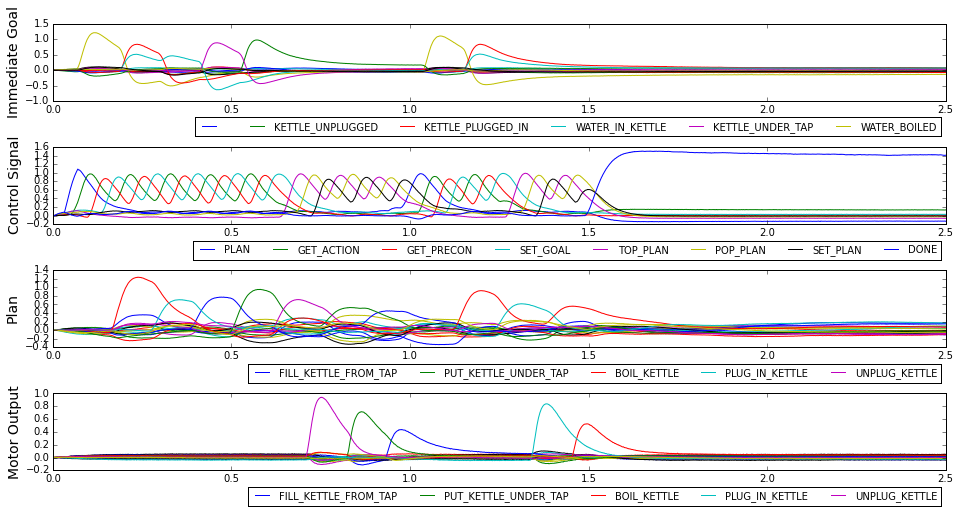

WATER
{'TEMPERATURE': 'BOILED'}
IN-KETTLE
------------------
KETTLE
{'PLUGGED': 'PLUGGED_IN'}
UNDER-TAP
------------------
TAP
{'OFFON': 'OFF'}
------------------
COUNTER
{}
------------------


In [6]:
plot_results(sim)
world.print_state()

# plot_spikes(sim)  # Uncomment this line to generate a plot with spike rasters.